In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats
import numpy as np
import scipy.stats as stats
import csv
import itertools

from sklearn import model_selection, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn import tree, svm, metrics
from os import system
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

#### Fonction d'affichage de prédiction

In [2]:
def affichage(x):
    print(x)
    x = str(x)
    if(x == "[0]"):
        print("Claude ne part pas")
    elif(x == "[1]"):
        print("Claude part")
    else:
        print("ERREUR")

#### Fonction de conversion des départs binaires en format string

In [3]:
def depart_labels(x):
    x = str(x)
    if(x == "0"):
        return "Stay"
    elif(x == "1"):
        return "Left"
    else:
        print("ERREUR")

#### Fonction d'affichage des matrices de confusion

In [4]:
def print_nice_conf_matrix(y, cnf_matrix):

   classes = range(0,(len(np.unique(y))))

   plt.figure()

   plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
   plt.title("Matrice de confusion")
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes)
   plt.yticks(tick_marks, classes)

   for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
       plt.text(j, i, cnf_matrix[i, j],
                horizontalalignment = "center",
                color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

   plt.ylabel('Vrais labels')
   plt.xlabel('Labels prédits')
   plt.show()

#### Lecture et stockage du fichier

In [5]:
employes = pd.read_csv("DataBaseTrain/depart_employes.csv",sep=";",header=0)
display(employes.head(10))

Satisfaction  derniere_evaluation  Nombre_de_projets  \
0          0.41                 0.54                  2   
1          0.87                 0.88                  5   
2          0.45                 0.48                  2   
3          0.40                 0.46                  2   
4          0.10                 0.80                  7   
5          0.09                 0.89                  6   
6          0.84                 0.74                  3   
7          0.40                 0.55                  2   
8          0.57                 0.70                  3   
9          0.40                 0.54                  2   

   Nombre_heures_mensuelles_moyenne  Temps_passe_dans_entreprise  \
0                               152                            3   
1                               269                            5   
2                               158                            3   
3                               127                            3   
4                               281                            4   
5                               276                            4   
6                               182                            4   
7                               147                            3   
8                               273                            6   
9                               148                            3   

   Accident_du travail  depart  promotion_5_dernieres_annees    Service  \
0                    0       1                             0  technical   
1                    0       1                             0  technical   
2                    0       1                             0  technical   
3                    0       1                             0  technical   
4                    0       1                             0  technical   
5                    0       1                             0  technical   
6                    0       1                             0  technical   
7                    0       1                             0    support   
8                    0       1                             0    support   
9                    0       1                             0    support   

  niveau_salaire  
0            low  
1            low  
2            low  
3            low  
4            low  
5            low  
6            low  
7            low  
8            low  
9            low

In [6]:
def resumetable(df):
    print("Format de la base : {}".format(df.shape))
    summary = pd.DataFrame(df.dtypes,columns=["dtypes"]).reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name","dtypes"]]
    summary["Missing"] = df.isnull().sum().values
    summary["Uniques"] = df.nunique().values
    summary["First value"] = df.iloc[0].values
    summary["Second value"] = df.iloc[1].values
    summary["Third value"] = df.iloc[2].values
    return summary
        
display(resumetable(employes))

Format de la base : (14960, 10)


Name   dtypes  Missing  Uniques First value  \
0                      Satisfaction  float64        0       92        0.41   
1               derniere_evaluation  float64        0       65        0.54   
2                 Nombre_de_projets    int64        0        6           2   
3  Nombre_heures_mensuelles_moyenne    int64        0      215         152   
4       Temps_passe_dans_entreprise    int64        0        8           3   
5               Accident_du travail    int64        0        2           0   
6                            depart    int64        0        2           1   
7      promotion_5_dernieres_annees    int64        0        2           0   
8                           Service   object        0       10   technical   
9                    niveau_salaire   object        0        3         low   

  Second value Third value  
0         0.87        0.45  
1         0.88        0.48  
2            5           2  
3          269         158  
4            5           3  
5            0           0  
6            1           1  
7            0           0  
8    technical   technical  
9          low         low

In [7]:
display(employes.describe())

Satisfaction  derniere_evaluation  Nombre_de_projets  \
count  14960.000000         14960.000000       14960.000000   
mean       0.613247             0.716186           3.803810   
std        0.248491             0.171119           1.230916   
min        0.090000             0.360000           2.000000   
25%        0.440000             0.560000           3.000000   
50%        0.640000             0.720000           4.000000   
75%        0.820000             0.870000           5.000000   
max        1.000000             1.000000           7.000000   

       Nombre_heures_mensuelles_moyenne  Temps_passe_dans_entreprise  \
count                      14960.000000                 14960.000000   
mean                         201.058021                     3.497460   
std                           49.907593                     1.461082   
min                           96.000000                     2.000000   
25%                          156.000000                     3.000000   
50%                          200.000000                     3.000000   
75%                          245.000000                     4.000000   
max                          310.000000                    10.000000   

       Accident_du travail        depart  promotion_5_dernieres_annees  
count         14960.000000  14960.000000                  14960.000000  
mean              0.144920      0.236096                      0.021257  
std               0.352032      0.424696                      0.144244  
min               0.000000      0.000000                      0.000000  
25%               0.000000      0.000000                      0.000000  
50%               0.000000      0.000000                      0.000000  
75%               0.000000      0.000000                      0.000000  
max               1.000000      1.000000                      1.000000

#### Répartition des départs en fonction des niveaux de salaire

In [8]:
fig = px.histogram(employes, x="niveau_salaire",color="depart")
fig.show()

#### Répartition des départs en fonction des services

In [9]:
fig = px.histogram(employes, x="Service",color="depart")
fig.show()

In [10]:
fig = px.histogram(employes, x="Nombre_heures_mensuelles_moyenne",color="depart")
fig.show()

Répartition des départs en fonction des heures mensuelles travaillées et du niveau de salaire associé

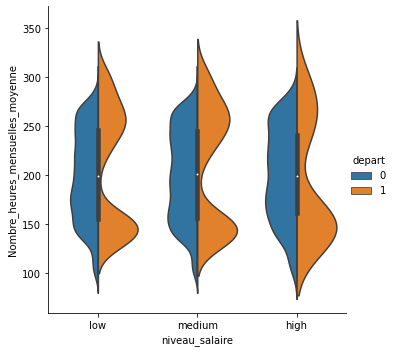

In [11]:
sns.catplot(x='niveau_salaire',y='Nombre_heures_mensuelles_moyenne',data=employes,hue='depart',kind='violin',split=True,heigh=8)

In [12]:
a = pd.crosstab(employes.depart,employes.Service)
print(scipy.stats.chi2_contingency(a))

(83.080736218351, 3.9398624341548155e-14, 9, array([[ 937.30989305,  601.19224599,  583.62245989,  561.46925134,
         481.25935829,  655.42941176,  689.04117647, 3141.17219251,
        1702.74144385, 2074.76256684],
       [ 289.69010695,  185.80775401,  180.37754011,  173.53074866,
         148.74064171,  202.57058824,  212.95882353,  970.82780749,
         526.25855615,  641.23743316]]))


#### Conversion des chaînes de caractères en entier

In [13]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

display(employes['Service'].unique())
display(resumetable(employes))

employes[['Service', 'niveau_salaire']] = ord_enc.fit_transform(employes[['Service', 'niveau_salaire']])

display(employes['Service'].unique())
display(resumetable(employes))

array(['technical', 'support', 'management', 'IT', 'product_mng',
       'marketing', 'sales', 'accounting', 'hr', 'RandD'], dtype=object)

Format de la base : (14960, 10)


Name   dtypes  Missing  Uniques First value  \
0                      Satisfaction  float64        0       92        0.41   
1               derniere_evaluation  float64        0       65        0.54   
2                 Nombre_de_projets    int64        0        6           2   
3  Nombre_heures_mensuelles_moyenne    int64        0      215         152   
4       Temps_passe_dans_entreprise    int64        0        8           3   
5               Accident_du travail    int64        0        2           0   
6                            depart    int64        0        2           1   
7      promotion_5_dernieres_annees    int64        0        2           0   
8                           Service   object        0       10   technical   
9                    niveau_salaire   object        0        3         low   

  Second value Third value  
0         0.87        0.45  
1         0.88        0.48  
2            5           2  
3          269         158  
4            5           3  
5            0           0  
6            1           1  
7            0           0  
8    technical   technical  
9          low         low

array([9., 8., 4., 0., 6., 5., 7., 2., 3., 1.])

Format de la base : (14960, 10)


Name   dtypes  Missing  Uniques  First value  \
0                      Satisfaction  float64        0       92         0.41   
1               derniere_evaluation  float64        0       65         0.54   
2                 Nombre_de_projets    int64        0        6         2.00   
3  Nombre_heures_mensuelles_moyenne    int64        0      215       152.00   
4       Temps_passe_dans_entreprise    int64        0        8         3.00   
5               Accident_du travail    int64        0        2         0.00   
6                            depart    int64        0        2         1.00   
7      promotion_5_dernieres_annees    int64        0        2         0.00   
8                           Service  float64        0       10         9.00   
9                    niveau_salaire  float64        0        3         1.00   

   Second value  Third value  
0          0.87         0.45  
1          0.88         0.48  
2          5.00         2.00  
3        269.00       158.00  
4          5.00         3.00  
5          0.00         0.00  
6          1.00         1.00  
7          0.00         0.00  
8          9.00         9.00  
9          1.00         1.00

#### Matrice de corrélation

<AxesSubplot:>

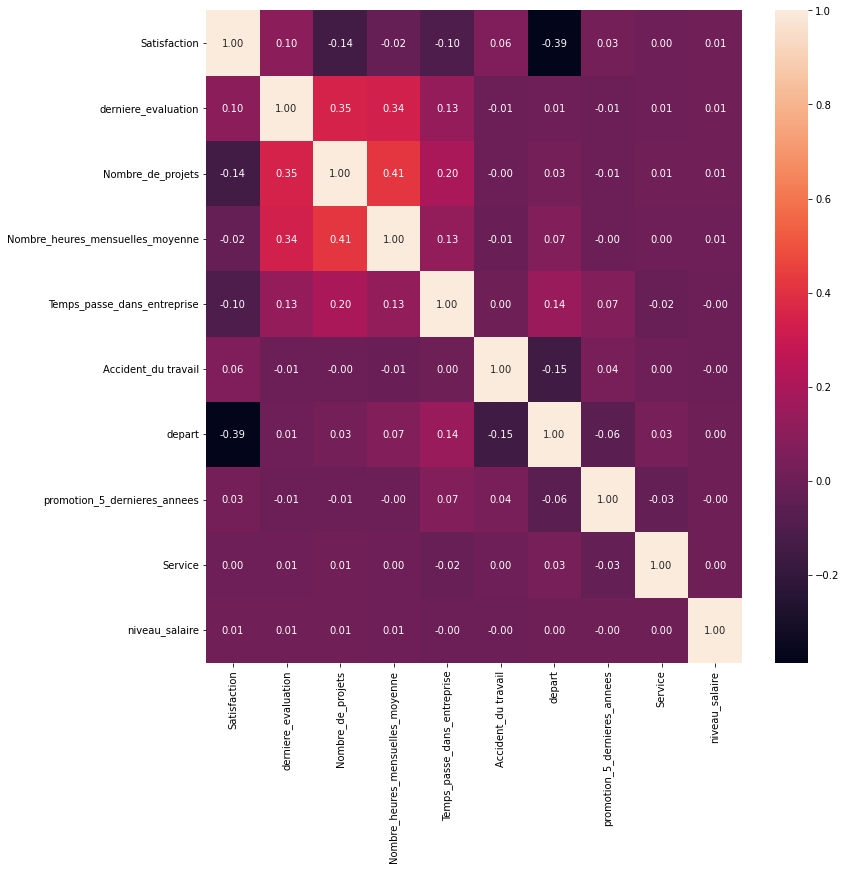

In [14]:
mat = employes.corr()
fig, ax = plt.subplots(figsize=(12,12))
c=sns.color_palette("rocket", as_cmap=True)
sns.heatmap(mat,annot=True,fmt=".2f",cmap=c)

#### VCramer

In [15]:
def VCramer(vec1,vec2):
    data = pd.crosstab(vec1,vec2)
    X2=stats.chi2_contingency(data,correction=False)[0]
    n = len(vec1)
    minDim = min(data.shape)-1
    V = np.sqrt((X2/n)/minDim)
    return V

lVars = ['depart','Satisfaction',
 'derniere_evaluation',
 'Nombre_de_projets',
 'Nombre_heures_mensuelles_moyenne',
 'Temps_passe_dans_entreprise',
 'Accident_du travail',
 'promotion_5_dernieres_annees',
 'Service',
 'niveau_salaire']

dictCramer={}
idx=0
for i1, crit1 in enumerate(lVars):
    print(f"{i1} ", end="",flush=True)
    for i2, crit2 in enumerate(lVars):
        tmpCramer={"var1":crit1,"var2":crit2}
        tmpCramer["VCramer"]=VCramer(employes[crit1],employes[crit2])
        dictCramer[idx]=tmpCramer.copy()
        idx=idx+1

dfCramer = pd.DataFrame.from_dict(dictCramer,orient="index")

print("Ok, fin des calculs du V de Cramer")
dfCramer.head()

0 1 2 3 4 5 6 7 8 9 Ok, fin des calculs du V de Cramer


var1                              var2   VCramer
0  depart                            depart  1.000000
1  depart                      Satisfaction  0.726683
2  depart               derniere_evaluation  0.409944
3  depart                 Nombre_de_projets  0.597387
4  depart  Nombre_heures_mensuelles_moyenne  0.490658

#### Matrice de correlation basée sur VCramer précédent

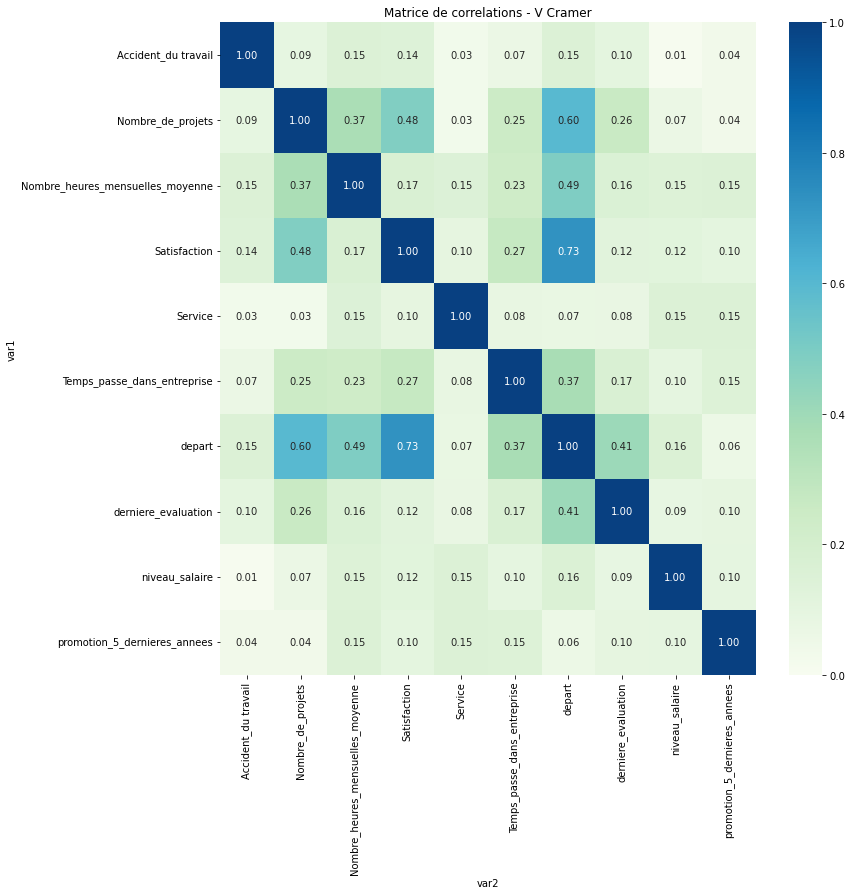

In [16]:
plt.rcParams['figure.figsize']=[12,12]
ax=sns.heatmap(dfCramer.pivot("var1","var2","VCramer"),
              vmin=0,vmax=1,cmap="GnBu",
              annot=True,fmt=".2f")
plt.title("Matrice de correlations - V Cramer")
plt.show();

#### Séparation des données en jeu de test et de train

In [17]:
Features = employes.drop(['depart'],axis="columns")
y = employes.depart

X_train, X_test, y_train, y_test = train_test_split(Features,y,test_size=0.3)

# Decision tree

In [18]:
clf_tree = tree.DecisionTreeClassifier(random_state=0, criterion='gini',max_depth=3)
clf_tree.fit(X_train,y_train)

y_train_pred=clf_tree.predict(X_train)

y_test_pred=clf_tree.predict(X_test)

print("Fiabilité decision tree : %0.3f" %clf_tree.score(X_train,y_train))
print("Fiabilité decision tree : %0.3f" %clf_tree.score(X_test, y_test))

Fiabilité decision tree : 0.952
Fiabilité decision tree : 0.953


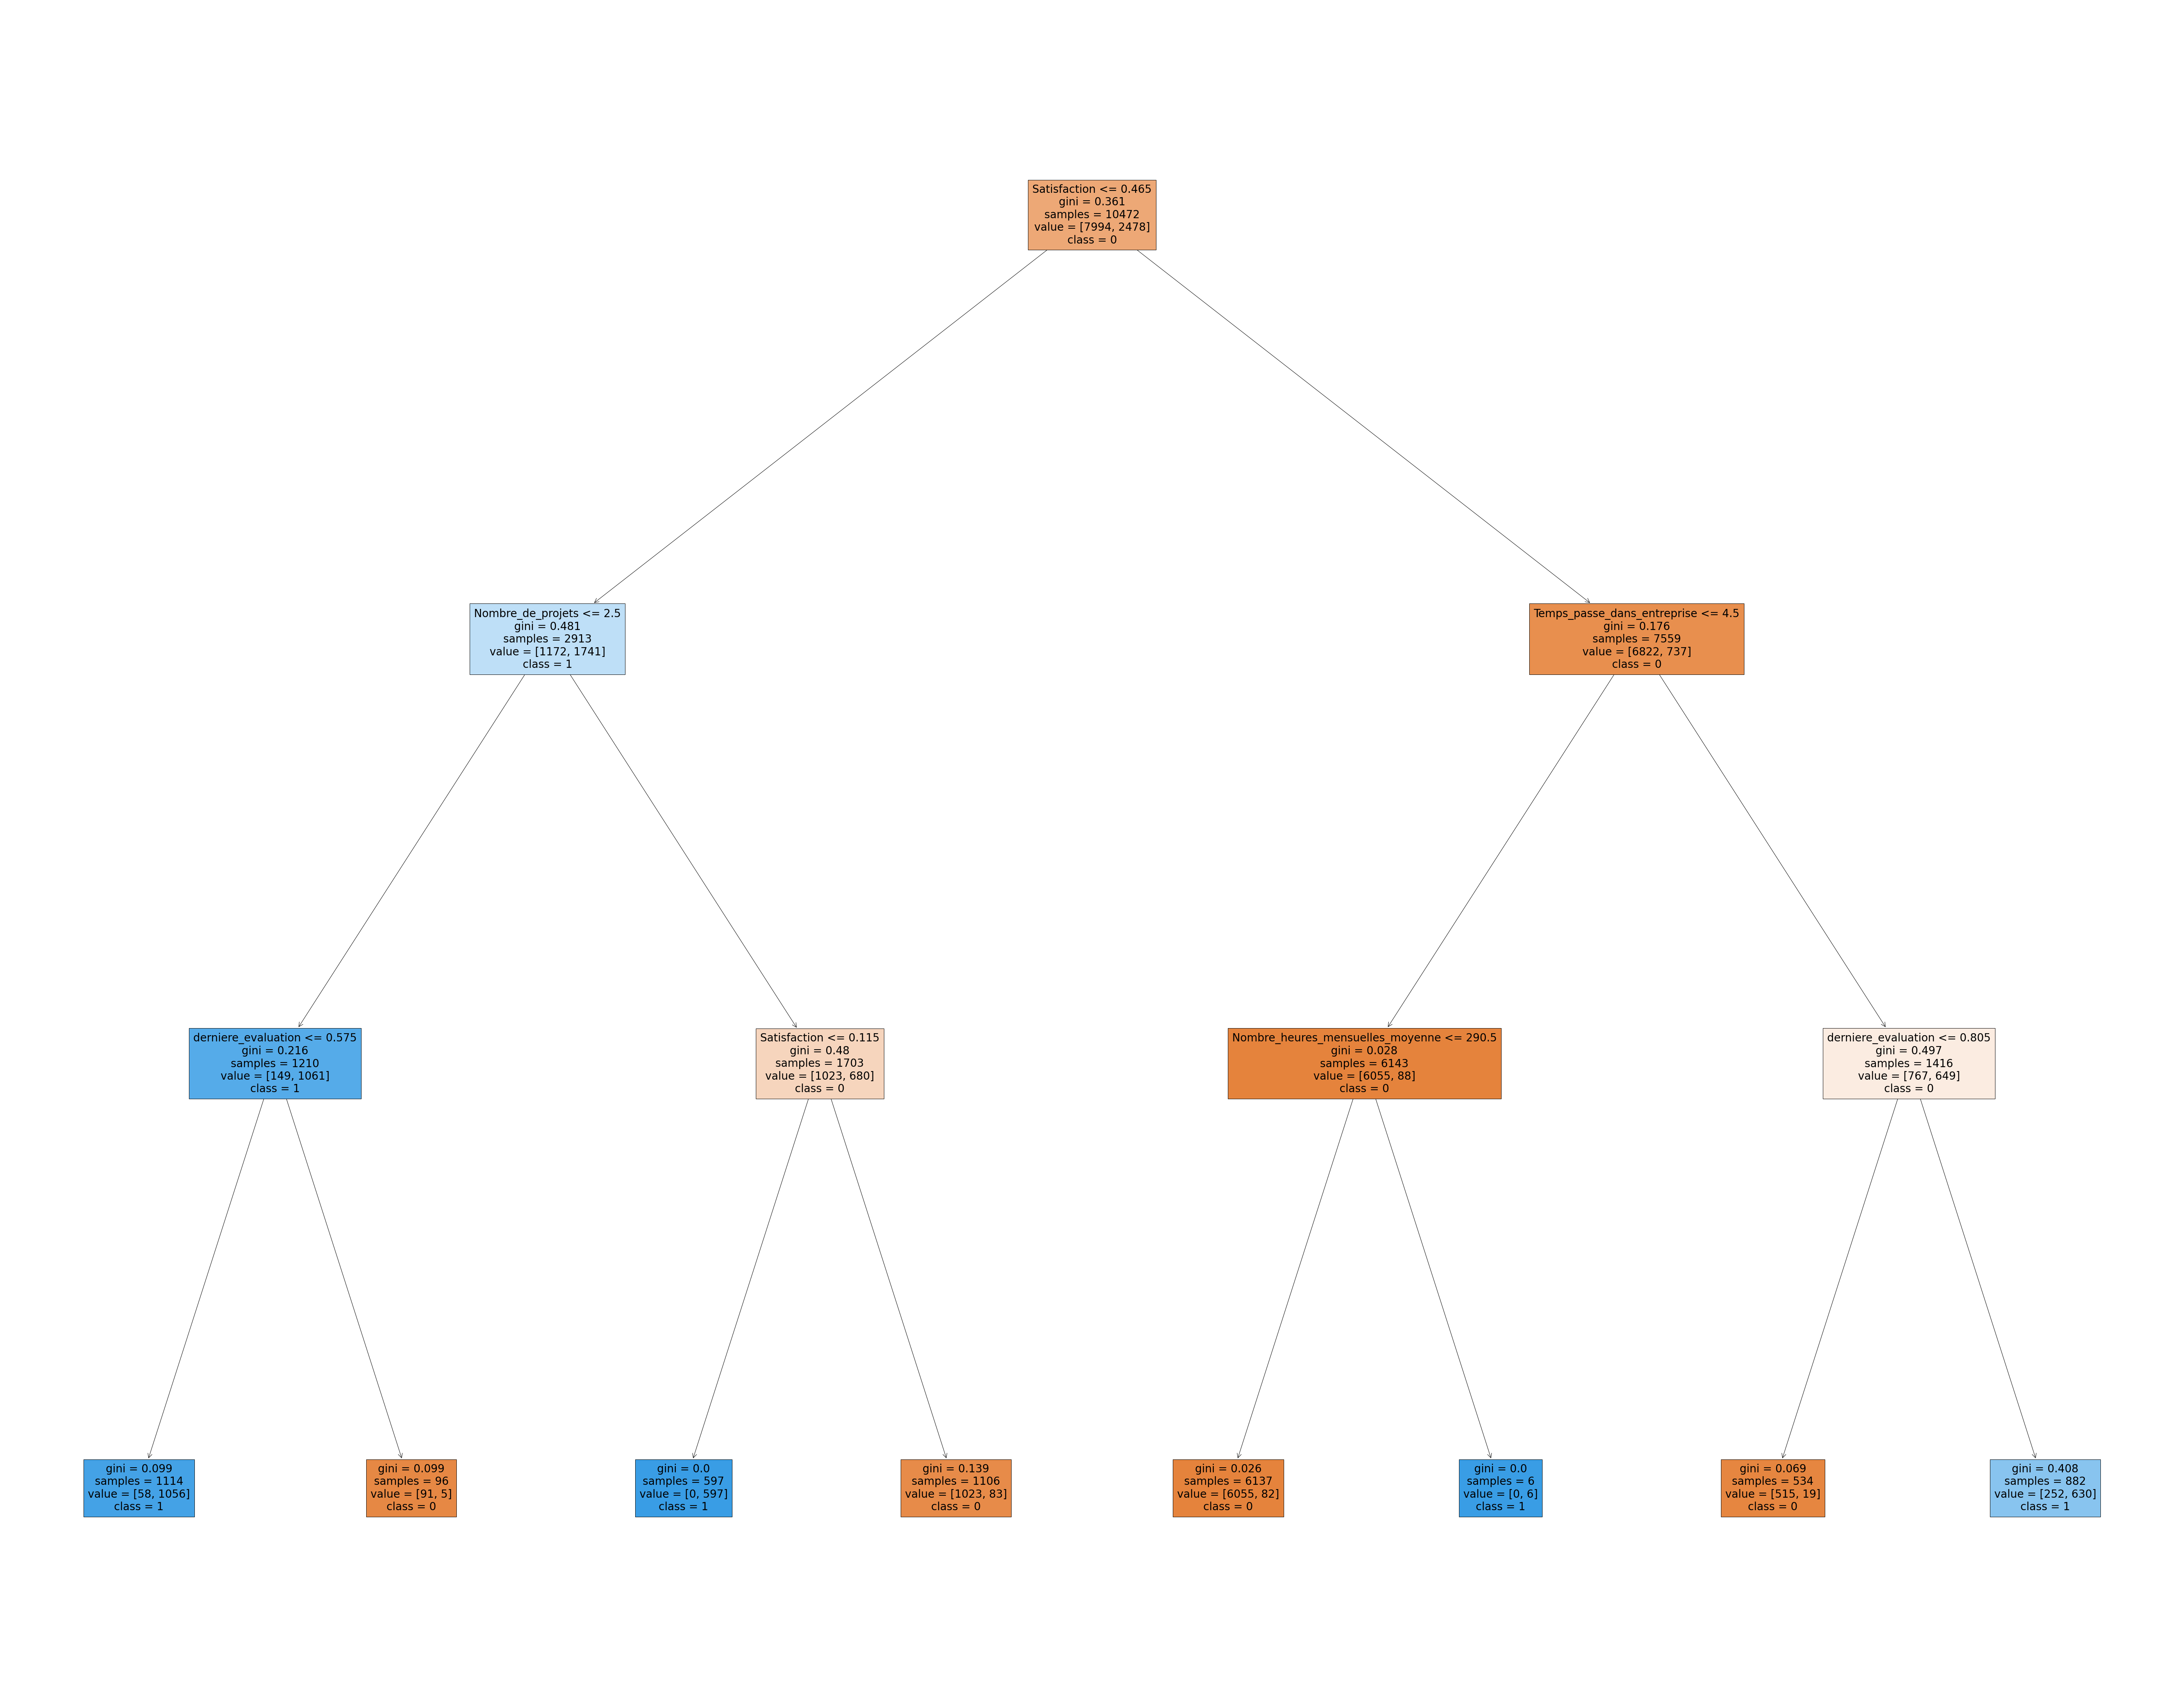

In [19]:
fig = plt.figure(figsize=(100,80))
_ = tree.plot_tree(clf_tree, 
                   feature_names=Features.columns,  
                   class_names=['0','1'],
                   filled=True)

In [20]:
fig.savefig("decistion_tree.png")

# Random forest

#### Modèle avec toutes les variables explicatives

In [21]:
clf_RF=RandomForestClassifier(n_estimators=100, max_depth=4)

clf_RF.fit(X_train,y_train)

y_train_pred=clf_RF.predict(X_train)

y_test_pred=clf_RF.predict(X_test)

print("Fiabilité random forest : %0.3f" %clf_RF.score(X_train,y_train))
print("Fiabilité random forest : %0.3f" %clf_RF.score(X_test, y_test))

Fiabilité random forest : 0.969
Fiabilité random forest : 0.965


#### Essai de prédiction d'un enregistrement

In [22]:
affichage(clf_RF.predict([[0.38,0.53,2,157,3,0,0,1.0,1.0]]))

[1]
Claude part


In [23]:
conf_matrixRF = confusion_matrix(y_test,y_test_pred)

# Logistic Regression

In [24]:
clf_log_reg = LogisticRegression()

clf_log_reg.fit(X_train, y_train)

y_train_pred=clf_log_reg.predict(X_train)

y_test_pred=clf_log_reg.predict(X_test)

print("Fiabilité logistic regression : %0.3f" %clf_log_reg.score(X_train,y_train))
print("Fiabilité logistic regression : %0.3f" %clf_log_reg.score(X_test, y_test))

print("RMSE train : %0.3f" %np.sqrt(mean_squared_error(y_train,y_train_pred)))
print("RMSE test : %0.3f" %np.sqrt(mean_squared_error(y_test,y_test_pred)))

Fiabilité logistic regression : 0.766
Fiabilité logistic regression : 0.778
RMSE train : 0.484
RMSE test : 0.471


C:\Users\Nperi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [25]:
affichage(clf_log_reg.predict([[0.38,0.53,2,157,3,0,0,1.0,1.0]]))

[0]
Claude ne part pas


In [27]:
conf_matrixLR = confusion_matrix(y_test,y_test_pred)

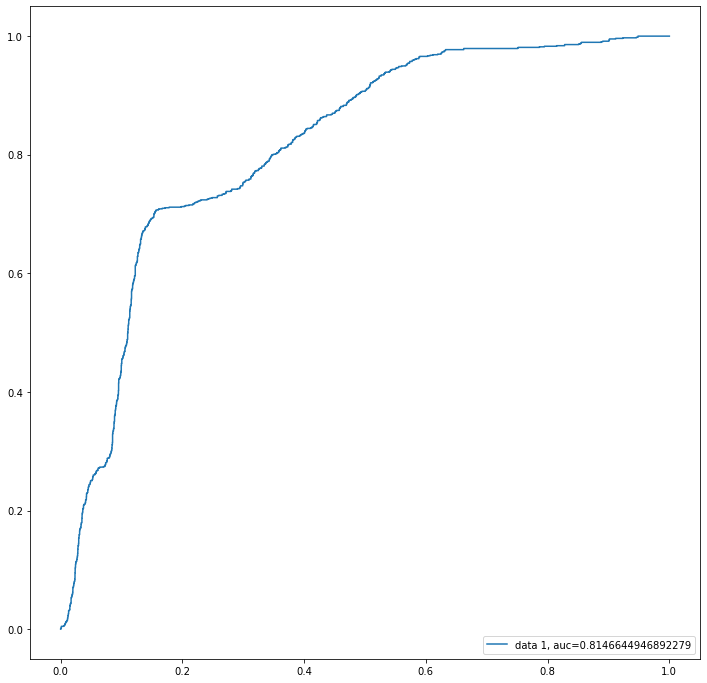

In [28]:
y_pred_proba = clf_log_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# KNN

In [30]:
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train, y_train)

y_train_pred=clf_knn.predict(X_train)

y_test_pred=clf_knn.predict(X_test)

print("Fiabilité logistic regression : %0.3f" %clf_knn.score(X_train,y_train))
print("Fiabilité logistic regression : %0.3f" %clf_knn.score(X_test, y_test))

Fiabilité logistic regression : 0.941
Fiabilité logistic regression : 0.936


In [31]:
affichage(clf_knn.predict([[0.38,0.53,2,157,3,0,0,1.0,1.0]]))

[1]
Claude part


In [33]:
conf_matrixKNN = confusion_matrix(y_test,y_test_pred)

# Support Vector Machine

In [34]:
clf_SVM = svm.SVC(gamma='scale', kernel='linear').fit(X_train, y_train)

y_train_pred=clf_SVM.predict(X_train)

y_test_pred=clf_SVM.predict(X_test)

print("Fiabilité SVM : %0.3f" %clf_SVM.score(X_train,y_train))
print("Fiabilité SVM : %0.3f" %clf_SVM.score(X_test, y_test))

Fiabilité SVM : 0.807
Fiabilité SVM : 0.817


In [35]:
affichage(clf_SVM.predict([[0.38,0.53,2,157,3,0,0,1.0,1.0]]))

[0]
Claude ne part pas


In [37]:
conf_matrixSVM = confusion_matrix(y_test,y_test_pred)

# Test sur un jeu de données externes

In [52]:
DB_test=pd.read_csv("DataBaseTest/depart_employes_test.csv",sep=";",header=0)

with open('DataBaseTest/employes_predict.csv', 'w', newline='') as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(['Satisfaction',
                    'derniere_evaluation',
                    'Nombre_de_projets',
                    'Nombre_heures_mensuelles_moyenne',
                    'Temps_passe_dans_entreprise',
                    'Accident_du travail',
                    'promotion_5_dernieres_annees',
                    'Service',
                    'niveau_salaire',
                    'random forest',
                    'logistic regression',
                    'knn',
                    'svm',
                    'expected'])
    for index, row in DB_test.iterrows():
        a = int(clf_RF.predict([[row['Satisfaction'], 
                              row['derniere_evaluation'], 
                              row['Nombre_de_projets'], 
                              row['Nombre_heures_mensuelles_moyenne'], 
                              row['Temps_passe_dans_entreprise'], 
                              row['Accident_du travail'], 
                              row['promotion_5_dernieres_annees'],
                              row['Service'], 
                              row['niveau_salaire']]]))
        b = int(clf_log_reg.predict([[row['Satisfaction'], 
                              row['derniere_evaluation'], 
                              row['Nombre_de_projets'], 
                              row['Nombre_heures_mensuelles_moyenne'], 
                              row['Temps_passe_dans_entreprise'], 
                              row['Accident_du travail'], 
                              row['promotion_5_dernieres_annees'],
                              row['Service'], 
                              row['niveau_salaire']]]))
        c = int(clf_knn.predict([[row['Satisfaction'], 
                              row['derniere_evaluation'], 
                              row['Nombre_de_projets'], 
                              row['Nombre_heures_mensuelles_moyenne'], 
                              row['Temps_passe_dans_entreprise'], 
                              row['Accident_du travail'], 
                              row['promotion_5_dernieres_annees'],
                              row['Service'], 
                              row['niveau_salaire']]]))
        d = int(clf_SVM.predict([[row['Satisfaction'], 
                              row['derniere_evaluation'], 
                              row['Nombre_de_projets'], 
                              row['Nombre_heures_mensuelles_moyenne'], 
                              row['Temps_passe_dans_entreprise'], 
                              row['Accident_du travail'], 
                              row['promotion_5_dernieres_annees'],
                              row['Service'], 
                              row['niveau_salaire']]]))
        writer.writerow([row['Satisfaction'], 
                         row['derniere_evaluation'], 
                         row['Nombre_de_projets'], 
                         row['Nombre_heures_mensuelles_moyenne'], 
                         row['Temps_passe_dans_entreprise'], 
                         row['Accident_du travail'], 
                         row['promotion_5_dernieres_annees'], 
                         row['Service'], 
                         row['niveau_salaire'],
                         depart_labels(a),
                         depart_labels(b),
                         depart_labels(c),
                         depart_labels(d)])

In [53]:
DB_expected=pd.read_csv("DataBaseTest/depart_employes_expected.csv",sep=";",header=0)

DB_test=pd.read_csv("DataBaseTest/employes_predict.csv",sep=";",header=0)

l = []
i=0

for index, row in DB_expected.iterrows():
    l.append(depart_labels(row['depart']))

for index, row in DB_test.iterrows():
    DB_test['expected'] = l[i]
    i = i + 1

DB_test.to_csv("DataBaseTest/employes_predict.csv", index=False)

# Matrices de confusion

In [ ]:
print("Matrice de confusion Random Forest")
print_nice_conf_matrix(y, conf_matrixRF)
print("Matrice de confusion Logistic Regression")
print_nice_conf_matrix(y, conf_matrixLR)
print("Matrice de confusion KNN")
print_nice_conf_matrix(y, conf_matrixKNN)
print("Matrice de confusion SVM")
print_nice_conf_matrix(y, conf_matrixSVM)

# Pistes d'optimisation

In [ ]:
linmodel = LogisticRegression()
rfe = RFE(estimator=linmodel, n_features_to_select=6, step=1, verbose=3)
rfe.fit(X_train,y_train)
var_sel = rfe.get_support()
elimination = rfe.ranking_

plt.figure(figsize=(16,3))
plt.subplot(211)
plt.matshow(var_sel.reshape(1,-1), cmap = 'gray_r',fignum=False)
plt.xlabel('Feature selection')
plt.yticks([]);
plt.subplot(212)
plt.matshow(elimination.reshape(1,-1), cmap = 'gray_r',fignum=False)
plt.xlabel('Feature selection')
plt.yticks([]);

In [ ]:
# report which features were selected by RFE
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define dataset
names = Features.columns
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# fit RFE
rfe.fit(Features, y)
# summarize all features
for i in range(Features.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (names[i], rfe.support_[i], rfe.ranking_[i]))

#### Ajout de features en combinant d'autres features

In [ ]:
employes['heures_totales'] = employes['Nombre_heures_mensuelles_moyenne']*12*employes['Temps_passe_dans_entreprise']
employes.head()

In [ ]:
employes['projets_par_années'] = employes['Nombre_de_projets']/employes['Temps_passe_dans_entreprise']
employes.head()

In [ ]:
employes['satisf_eval'] = employes['Satisfaction']/employes['derniere_evaluation']
employes.head()

In [ ]:
mat = employes.corr()
fig, ax = plt.subplots(figsize=(12,12))
c=sns.color_palette("rocket", as_cmap=True)
sns.heatmap(mat,annot=True,fmt=".2f",cmap=c)

In [ ]:
lVars = ['depart','Satisfaction',
 'derniere_evaluation',
 'Nombre_de_projets',
 'Nombre_heures_mensuelles_moyenne',
 'Temps_passe_dans_entreprise',
 'Accident_du travail',
 'promotion_5_dernieres_annees',
 'Service',
 'niveau_salaire',
 'heures_totales',
 'projets_par_années',
 'satisf_eval']

dictCramer={}
idx=0
for i1, crit1 in enumerate(lVars):
    print(f"{i1} ", end="",flush=True)
    for i2, crit2 in enumerate(lVars):
        tmpCramer={"var1":crit1,"var2":crit2}
        tmpCramer["VCramer"]=VCramer(employes[crit1],employes[crit2])
        dictCramer[idx]=tmpCramer.copy()
        idx=idx+1

dfCramer = pd.DataFrame.from_dict(dictCramer,orient="index")

print("Ok, fin des calculs du V de Cramer")
dfCramer.head(12)

In [ ]:
plt.rcParams['figure.figsize']=[12,12]
ax=sns.heatmap(dfCramer.pivot("var1","var2","VCramer"),
              vmin=0,vmax=1,cmap="GnBu",
              annot=True,fmt=".2f")
plt.title("Matrice de correlations - V Cramer")
plt.show();

#### Séparation des données en jeu de test et de train

In [ ]:
Features = employes[['Satisfaction','Accident_du travail','heures_totales','projets_par_années','satisf_eval']]
y = employes.depart
display(Features.head())

X_train, X_test, y_train, y_test = train_test_split(Features,y,test_size=0.3)

# Logistic Regression

In [ ]:
clf_log_reg2 = LogisticRegression()

clf_log_reg2.fit(X_train, y_train)

y_train_pred=clf_log_reg2.predict(X_train)

y_test_pred=clf_log_reg2.predict(X_test)

print("Fiabilité logistic regression : %0.2f" %clf_log_reg2.score(X_train,y_train))
print("Fiabilité logistic regression : %0.2f" %clf_log_reg2.score(X_test, y_test))

print("RMSE train : %0.3f" %np.sqrt(mean_squared_error(y_train,y_train_pred)))
print("RMSE test : %0.3f" %np.sqrt(mean_squared_error(y_test,y_test_pred)))